<a href="https://colab.research.google.com/github/EricEricEricJin/ECE539-Group-Project/blob/master/music_speech_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: [Classifying Music and Speech with Machine Learning](https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e)

11/2 Update:
- Enabled variable input sample number
- Rewrote all code by myself in modern TF and Keras
- Tried majority-voting instead of FIR filter, and it works better, but FPR still too high.

- Next step: try vocal separation before feeding into NN.  

11/18 Update:
- Use this notebook to train CNN only
- Used new `xxm_splitted`

In [ ]:
####################
# Import libraries #
####################

from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras

import os
import datetime

Mounted at /content/drive


In [ ]:
#############################
# Load xxm_splitted dataset #
#############################

def get_waveforms_labels(fp, INPUT_SIZE):
  def _get_waveform(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio)

  def _get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

  waveforms = []
  labels = []
  for dirname, _, filenames in os.walk(fp):
      if "xxm_singing" in dirname or "xxm_speech" in dirname:
          print(dirname, filenames)
          for filename in filenames:
            filepath = os.path.join(dirname, filename)
            for i in range(661500 // INPUT_SIZE):
              waveforms.append(_get_waveform(filepath)[i*INPUT_SIZE : (i+1)*INPUT_SIZE])
              labels.append(_get_label(filepath))
  return waveforms, labels

CHUNK_SAMPLE = 661500 // 5

fp = "/content/drive/My Drive/Colab Notebooks/ECE539_Project"
categories = ["xxm_speech", "xxm_singing"]
waveforms, labels = get_waveforms_labels(fp, CHUNK_SAMPLE)

# Merge to tfds
_ds = tf.data.Dataset.from_tensor_slices((waveforms, labels))
waveform_ds = _ds.shuffle(buffer_size=len(_ds))

In [ ]:
##########################
# Check waveform dataset #
##########################
import IPython

for i in waveform_ds.take(5):
  ret = IPython.display.Audio(i[0], rate=22050)
  print(i[1])
  IPython.display.display(ret)


tf.Tensor(b'xxm_singing', shape=(), dtype=string)


tf.Tensor(b'xxm_speech', shape=(), dtype=string)
tf.Tensor(b'xxm_singing', shape=(), dtype=string)


tf.Tensor(b'xxm_singing', shape=(), dtype=string)


tf.Tensor(b'xxm_singing', shape=(), dtype=string)


In [ ]:
##########################
# Convert to spectrogram #
##########################

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def get_spectrograms_labels(waveform, label):
  return tf.expand_dims(get_spectrogram(waveform), -1), label == categories

spectrogram_ds = waveform_ds.map(get_spectrograms_labels)
print(len(spectrogram_ds))

for i in spectrogram_ds:
  print(i[0].shape, i[1])
  break

2740
(1032, 129, 1) tf.Tensor([False  True], shape=(2,), dtype=bool)


In [ ]:
for i in spectrogram_ds.take(1):
  print(i[1])

tf.Tensor([False  True], shape=(2,), dtype=bool)


In [ ]:
batch_size = 32 # WHY?

train_ds, val_ds = keras.utils.split_dataset(spectrogram_ds, left_size=0.8)
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

for _ in spectrogram_ds.take(1):
  input_shape = _[0].shape

for _ in train_ds.take(1):
  b_input_shape = _[0].shape

print('Unbatched input shape:', input_shape)
print('Batched input shape:', b_input_shape)

Unbatched input shape: (1032, 129, 1)
Batched input shape: (32, 1032, 129, 1)


In [ ]:
for i in train_ds.take(1):
  print(i[1])

tf.Tensor(
[[False  True]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [ True False]], shape=(32, 2), dtype=bool)


In [ ]:
norm_layer = keras.layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# Resizing is the hyper param to be tuned.

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.Resizing(512, 64))
model.add(norm_layer)
model.add(keras.layers.Conv2D(32, 3, activation='relu'))
model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 512, 64, 1)        0         
                                                                 
 normalization (Normalizati  (None, 512, 64, 1)        3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 510, 62, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 508, 60, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 30, 64)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 254, 30, 64)       0

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

EPOCHS = 30
checkpoint_filepath = f"/content/drive/My Drive/Colab Notebooks/ECE539_Project/ms_clf_weights_N={CHUNK_SAMPLE}"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop_callback = keras.callbacks.EarlyStopping(verbose=1, patience=10)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback, earlystop_callback],
)

Epoch 1/30
69/69 [==============================] - 24s 176ms/step - loss: 0.6648 - accuracy: 0.8650 - val_loss: 0.1937 - val_accuracy: 0.9234
Epoch 2/30
69/69 [==============================] - 12s 169ms/step - loss: 0.1676 - accuracy: 0.9416 - val_loss: 0.1488 - val_accuracy: 0.9398
Epoch 3/30
69/69 [==============================] - 10s 145ms/step - loss: 0.0881 - accuracy: 0.9708 - val_loss: 0.0899 - val_accuracy: 0.9708
Epoch 4/30
69/69 [==============================] - 7s 103ms/step - loss: 0.0638 - accuracy: 0.9808 - val_loss: 0.1806 - val_accuracy: 0.9489
Epoch 5/30
69/69 [==============================] - 10s 148ms/step - loss: 0.0460 - accuracy: 0.9872 - val_loss: 0.0732 - val_accuracy: 0.9763
Epoch 6/30
69/69 [==============================] - 7s 104ms/step - loss: 0.0390 - accuracy: 0.9872 - val_loss: 0.0690 - val_accuracy: 0.9763
Epoch 7/30
69/69 [==============================] - 12s 174ms/step - loss: 0.0222 - accuracy: 0.9941 - val_loss: 0.0603 - val_accuracy: 0.9781
E

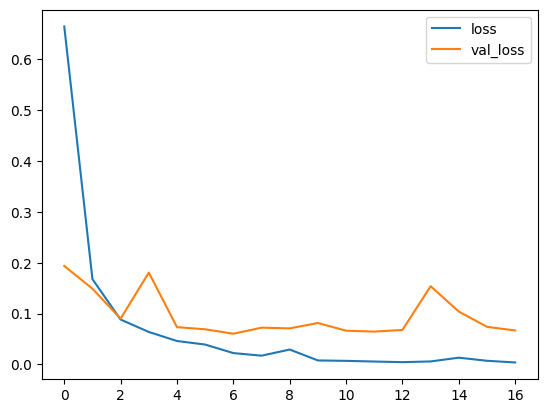

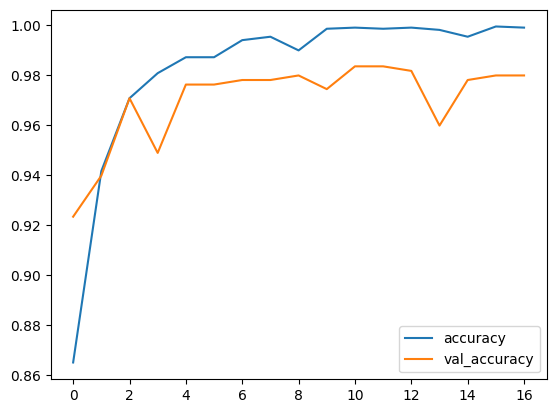

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()